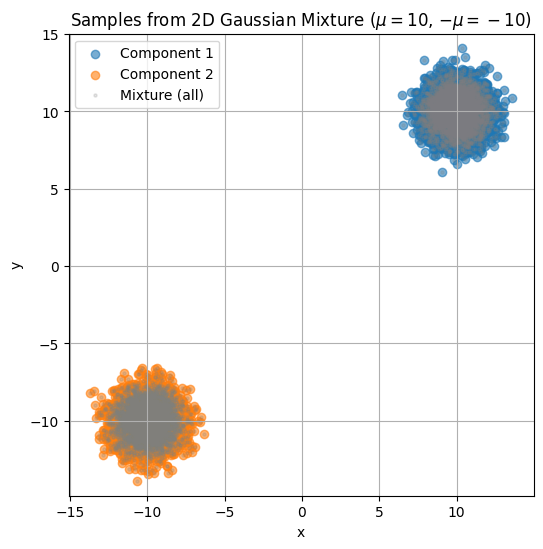

In [9]:
import torch
import matplotlib.pyplot as plt

# Set the mean value for mixture components
mu = 10

# Number of samples per component
n_samples = 5000

# Means for two components in 2D
means = torch.tensor([[mu, mu], [-mu, -mu]], dtype=torch.float)

# Covariance (identity for both)
cov = torch.eye(2)

# Sample standard normal, then shift by mean
def sample_gaussian(mean, cov, n):
    return torch.randn(n, 2) @ cov.sqrt() + mean

# Generate samples for each component
samples_1 = sample_gaussian(means[0], cov, n_samples)
samples_2 = sample_gaussian(means[1], cov, n_samples)

# Stack together
mixture_samples = torch.cat([samples_1, samples_2], dim=0)

# Visualize the samples
plt.figure(figsize=(6, 6))
plt.scatter(samples_1[:, 0], samples_1[:, 1], alpha=0.6, label='Component 1')
plt.scatter(samples_2[:, 0], samples_2[:, 1], alpha=0.6, label='Component 2')
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], s=5, color='gray', alpha=0.2, label='Mixture (all)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from 2D Gaussian Mixture ($\mu={}$, $-\mu={}$)'.format(mu, -mu))
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()




Total samples: 10000
Batch size: 256
Batches per epoch: 40
Total training steps: 4000


Epoch 1/100 | Average Loss: 92.3020


Epoch 11/100 | Average Loss: 36.9690


Epoch 21/100 | Average Loss: 12.0993


Epoch 31/100 | Average Loss: 3.6270


Epoch 41/100 | Average Loss: 1.6331


Epoch 51/100 | Average Loss: 1.3375


Epoch 61/100 | Average Loss: 1.3272


Epoch 71/100 | Average Loss: 1.3420


Epoch 81/100 | Average Loss: 1.3394


Epoch 91/100 | Average Loss: 1.2904


Epoch 100/100 | Average Loss: 1.3289


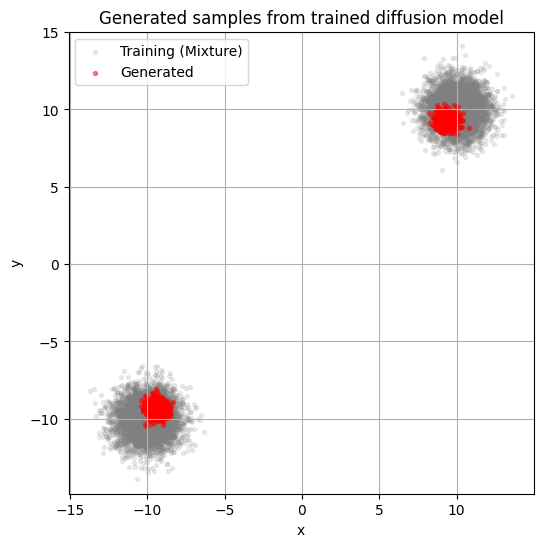

In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data and configs
data = mixture_samples.to(device)
n, d = data.shape
T = 100  # Number of diffusion steps

# Define the two-layer model with Sharp Sigmoid activation
class TwoLayerDiffusionModel(nn.Module):
    def __init__(self, d, sigmoid_sharpness=10.0):
        super().__init__()
        self.linear1 = nn.Linear(d, 1, bias=False)
        # self.sigmoid = nn.Sigmoid()
        self.sigmoid = nn.Tanh()
        self.linear2 = nn.Linear(1, d, bias=True)  # Added bias
        self.sharpness = sigmoid_sharpness  # Controls sigmoid steepness

    def forward(self, x):
        out = self.linear1(x)
        out = self.sigmoid(self.sharpness * out)  # Sharp sigmoid
        out = self.linear2(out)
        return out

model = TwoLayerDiffusionModel(d).to(device)

# Diffusion (DDPM-style) parameters
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Loss: predict the added noise
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Training configuration
epochs = 100  # number of passes through the entire dataset
batch_size = 256

# Create DataLoader for proper batching
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Total samples: {n}")
print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(dataloader)}")
print(f"Total training steps: {epochs * len(dataloader)}")

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for (x0_batch,) in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x0 = x0_batch.to(device)  # [batch_size, d]
        current_batch_size = x0.shape[0]
        
        # Sample random timesteps for this batch
        t = torch.randint(0, T, (current_batch_size,), device=device).long()
        noise = torch.randn_like(x0)

        alpha_bar_t = alpha_bars[t].view(-1, 1)
        xt = (alpha_bar_t.sqrt()) * x0 + (1 - alpha_bar_t).sqrt() * noise

        pred_noise = xt/alpha_bar_t.sqrt() - model(xt)
        loss = ((pred_noise - noise) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")

# Generation function (DDPM sampling)
@torch.no_grad()
def sample_ddpm(model, n_samples, d, T):
    x = torch.randn(n_samples, d).to(device)
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        # Model predicts x0 (clean sample), convert to noise prediction
        pred_x0 = model(x)
        pred_noise = x / alpha_bar_t.sqrt() - pred_x0
        coef_one = 1 / alpha_t.sqrt()
        coef_two = (1 - alpha_t) / (1 - alpha_bar_t).sqrt()
        # Update
        x = coef_one * (x - coef_two * pred_noise)
        if t > 0:
            noise = torch.randn_like(x)
            x = x + beta_t.sqrt() * noise  # add stochasticity for t > 0
    return x.cpu()

# Generate samples
gen_samples = sample_ddpm(model, 1000, d, T)

# Visualization
plt.figure(figsize=(6,6))
plt.scatter(data[:,0].cpu(), data[:,1].cpu(), alpha=0.15, label='Training (Mixture)', color='gray', s=8)
plt.scatter(gen_samples[:,0], gen_samples[:,1], alpha=0.5, label='Generated', color='red', s=8)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated samples from trained diffusion model')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()



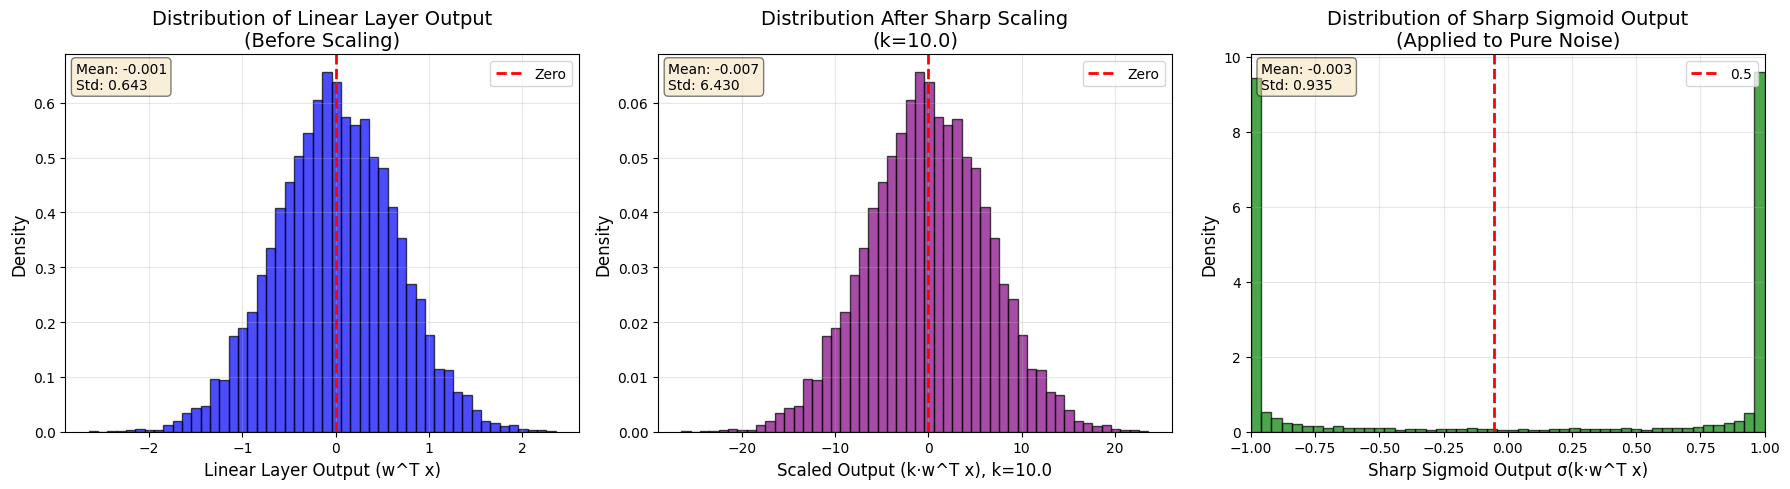


Statistics for 10000 pure noise samples:

Linear Layer Output (w^T x):
  Mean: -0.0007
  Std:  0.6430
  Min:  -2.6462
  Max:  2.3578

Scaled Output (k·w^T x) with k=10.0:
  Mean: -0.0067
  Std:  6.4295
  Min:  -26.4623
  Max:  23.5779

Sharp Sigmoid Output σ(k·w^T x):
  Mean: -0.0025
  Std:  0.9352
  Min:  -1.0000
  Max:  1.0000

Learned Weights and Biases:

Linear1 (w from input layer):
  w1: [0.6195278  0.16843827]
  ||w1||: 0.6420
  Direction: [0.9649707  0.26235786]

Linear2 (w from output layer):
  w2: [ 9.999025 10.011195]
  ||w2||: 14.1494
  Direction: [0.7066766 0.7075367]

Linear2 Bias (b2):
  b2: [-0.02652877  0.01287511]
  ||b2||: 0.0295

Sigmoid Sharpness Parameter:
  k: 10.0



In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Generate pure noise samples
n_noise_samples = 10000
pure_noise = torch.randn(n_noise_samples, d).to(device)

# Apply the model to get sigmoid activations
with torch.no_grad():
    # Get the output of the first linear layer
    linear1_output = model.linear1(pure_noise)  # Shape: (n_noise_samples, 1)
    
    # Apply sharp sigmoid activation
    sigmoid_output = model.sigmoid(model.sharpness * linear1_output)  # Shape: (n_noise_samples, 1)
    
    # Convert to numpy for plotting
    sigmoid_values = sigmoid_output.cpu().numpy().flatten()
    linear1_values = linear1_output.cpu().numpy().flatten()
    scaled_linear1_values = (model.sharpness * linear1_output).cpu().numpy().flatten()

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Histogram of linear layer output (before scaling)
axes[0].hist(linear1_values, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
axes[0].set_xlabel('Linear Layer Output (w^T x)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Distribution of Linear Layer Output\n(Before Scaling)', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0].legend()

mean_linear = linear1_values.mean()
std_linear = linear1_values.std()
axes[0].text(0.02, 0.98, f'Mean: {mean_linear:.3f}\nStd: {std_linear:.3f}', 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Histogram of scaled linear output (after sharp scaling)
axes[1].hist(scaled_linear1_values, bins=50, alpha=0.7, color='purple', edgecolor='black', density=True)
axes[1].set_xlabel(f'Scaled Output (k·w^T x), k={model.sharpness}', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title(f'Distribution After Sharp Scaling\n(k={model.sharpness})', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].legend()

mean_scaled = scaled_linear1_values.mean()
std_scaled = scaled_linear1_values.std()
axes[1].text(0.02, 0.98, f'Mean: {mean_scaled:.3f}\nStd: {std_scaled:.3f}', 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Histogram of sigmoid output
axes[2].hist(sigmoid_values, bins=50, alpha=0.7, color='green', edgecolor='black', density=True)
axes[2].set_xlabel('Sharp Sigmoid Output σ(k·w^T x)', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title(f'Distribution of Sharp Sigmoid Output\n(Applied to Pure Noise)', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].axvline(np.median(sigmoid_values), color='red', linestyle='--', linewidth=2, label='0.5')
axes[2].legend()
axes[2].set_xlim([min(sigmoid_values), max(sigmoid_values)])

mean_sigmoid = sigmoid_values.mean()
std_sigmoid = sigmoid_values.std()
axes[2].text(0.02, 0.98, f'Mean: {mean_sigmoid:.3f}\nStd: {std_sigmoid:.3f}', 
             transform=axes[2].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*70}")
print(f"Statistics for {n_noise_samples} pure noise samples:")
print(f"{'='*70}")
print(f"\nLinear Layer Output (w^T x):")
print(f"  Mean: {mean_linear:.4f}")
print(f"  Std:  {std_linear:.4f}")
print(f"  Min:  {linear1_values.min():.4f}")
print(f"  Max:  {linear1_values.max():.4f}")
print(f"\nScaled Output (k·w^T x) with k={model.sharpness}:")
print(f"  Mean: {mean_scaled:.4f}")
print(f"  Std:  {std_scaled:.4f}")
print(f"  Min:  {scaled_linear1_values.min():.4f}")
print(f"  Max:  {scaled_linear1_values.max():.4f}")
print(f"\nSharp Sigmoid Output σ(k·w^T x):")
print(f"  Mean: {mean_sigmoid:.4f}")
print(f"  Std:  {std_sigmoid:.4f}")
print(f"  Min:  {sigmoid_values.min():.4f}")
print(f"  Max:  {sigmoid_values.max():.4f}")

# Analyze the learned weights
with torch.no_grad():
    w1 = model.linear1.weight.cpu().numpy().flatten()
    w1_norm = np.linalg.norm(w1)
    
    w2 = model.linear2.weight.cpu().numpy().flatten()
    w2_norm = np.linalg.norm(w2)
    
    b2 = model.linear2.bias.cpu().numpy().flatten()
    
print(f"\n{'='*70}")
print(f"Learned Weights and Biases:")
print(f"{'='*70}")
print(f"\nLinear1 (w from input layer):")
print(f"  w1: {w1}")
print(f"  ||w1||: {w1_norm:.4f}")
print(f"  Direction: {w1 / (w1_norm + 1e-12)}")
print(f"\nLinear2 (w from output layer):")
print(f"  w2: {w2}")
print(f"  ||w2||: {w2_norm:.4f}")
print(f"  Direction: {w2 / (w2_norm + 1e-12)}")
print(f"\nLinear2 Bias (b2):")
print(f"  b2: {b2}")
print(f"  ||b2||: {np.linalg.norm(b2):.4f}")
print(f"\nSigmoid Sharpness Parameter:")
print(f"  k: {model.sharpness}")
print(f"{'='*70}\n")



Base mean μ_0: tensor([10., 10.])
Direction vector u: tensor([-1.,  1.])
Covariance matrix:
tensor([[1., 0.],
        [0., 1.]])

Generating 11 mixture distributions (S_0 to S_10)...
Each mixture has 2 components with 500 samples per component

S_0: μ_i^+ = [10. 10.], μ_i^- = [-10. -10.]
      ||μ_i^+|| = 14.1421, ||μ_i^-|| = 14.1421
S_1: μ_i^+ = [ 9. 11.], μ_i^- = [ -9. -11.]
      ||μ_i^+|| = 14.2127, ||μ_i^-|| = 14.2127
S_2: μ_i^+ = [ 8. 12.], μ_i^- = [ -8. -12.]
      ||μ_i^+|| = 14.4222, ||μ_i^-|| = 14.4222
S_3: μ_i^+ = [ 7. 13.], μ_i^- = [ -7. -13.]
      ||μ_i^+|| = 14.7648, ||μ_i^-|| = 14.7648
S_4: μ_i^+ = [ 6. 14.], μ_i^- = [ -6. -14.]
      ||μ_i^+|| = 15.2315, ||μ_i^-|| = 15.2315
S_5: μ_i^+ = [ 5. 15.], μ_i^- = [ -5. -15.]
      ||μ_i^+|| = 15.8114, ||μ_i^-|| = 15.8114
S_6: μ_i^+ = [ 4. 16.], μ_i^- = [ -4. -16.]
      ||μ_i^+|| = 16.4924, ||μ_i^-|| = 16.4924
S_7: μ_i^+ = [ 3. 17.], μ_i^- = [ -3. -17.]
      ||μ_i^+|| = 17.2627, ||μ_i^-|| = 17.2627
S_8: μ_i^+ = [ 2. 18.], μ_i

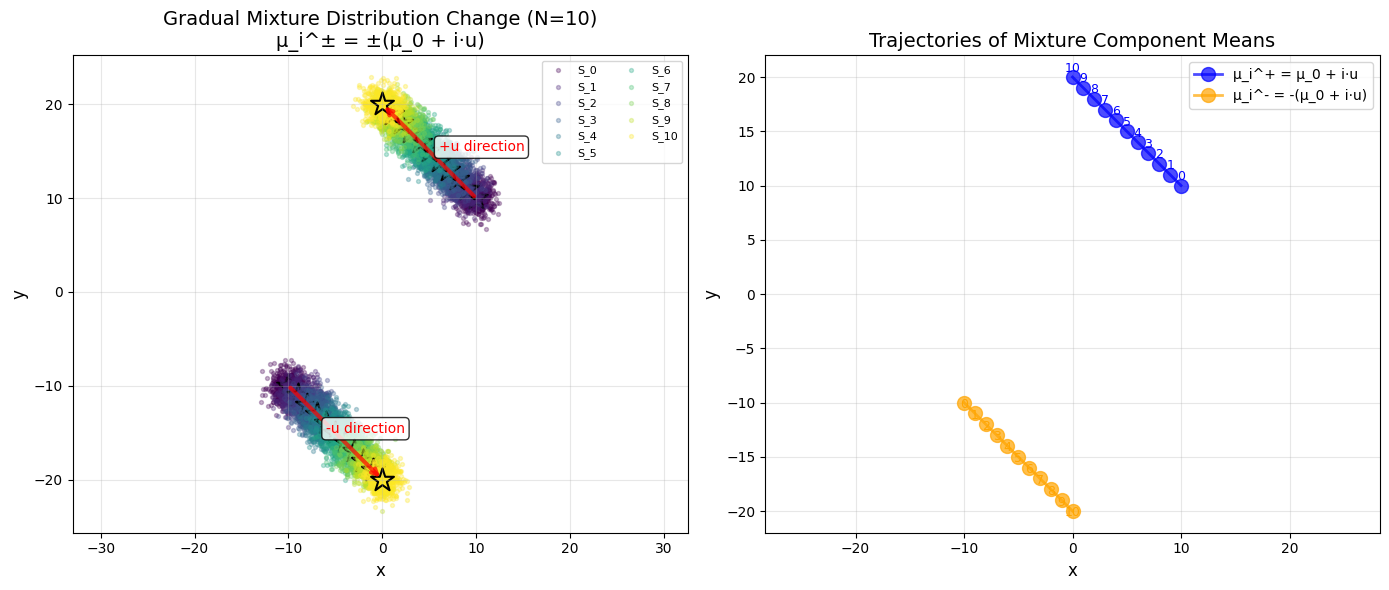


Statistical Summary for Each Mixture Distribution:

S_0 (Mixture):
  Component means: μ_i^+ = [10. 10.], μ_i^- = [-10. -10.]
  Overall empirical mean: [-0.03815604 -0.00518746]
  Overall empirical std:  [10.080287 10.122107]

S_1 (Mixture):
  Component means: μ_i^+ = [ 9. 11.], μ_i^- = [ -9. -11.]
  Overall empirical mean: [-0.04746835 -0.03467477]
  Overall empirical std:  [ 9.04087  11.054117]

S_2 (Mixture):
  Component means: μ_i^+ = [ 8. 12.], μ_i^- = [ -8. -12.]
  Overall empirical mean: [ 0.03896236 -0.01670537]
  Overall empirical std:  [ 8.011509 12.002909]

S_3 (Mixture):
  Component means: μ_i^+ = [ 7. 13.], μ_i^- = [ -7. -13.]
  Overall empirical mean: [-0.0324025   0.02603706]
  Overall empirical std:  [ 7.0804825 13.120699 ]

S_4 (Mixture):
  Component means: μ_i^+ = [ 6. 14.], μ_i^- = [ -6. -14.]
  Overall empirical mean: [-0.07400858 -0.048819  ]
  Overall empirical std:  [ 6.0649877 14.073765 ]

S_5 (Mixture):
  Component means: μ_i^+ = [ 5. 15.], μ_i^- = [ -5. -15.]


In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Configuration Parameters
# ============================
N = 10  # Number of mixture distributions to generate (S_0, S_1, ..., S_N)
n_samples_per_component = 500  # Number of samples per mixture component

# Define the base mean μ_0 and direction vector u
mu_0 = means[0]  # Starting mean (from first component: [mu, mu])
u = torch.tensor([-1.0, 1.0])  # Direction vector for gradual change

# Use the same covariance as the first distribution
cov_matrix = cov  # Identity covariance

print(f"Base mean μ_0: {mu_0}")
print(f"Direction vector u: {u}")
print(f"Covariance matrix:\n{cov_matrix}")
print(f"\nGenerating {N+1} mixture distributions (S_0 to S_{N})...")
print(f"Each mixture has 2 components with {n_samples_per_component} samples per component")
print(f"{'='*70}\n")

# ============================
# Generate Series of Mixture Samples
# ============================
all_samples = []  # List to store samples from each mixture distribution
all_positive_means = []  # List to store positive means (μ_0 + i*u)
all_negative_means = []  # List to store negative means (-(μ_0 + i*u))

for i in range(N+1):
    # Compute means for i-th mixture: +/- (μ_0 + i*u)
    mu_i_positive = mu_0 + i * u
    mu_i_negative = -(mu_0 + i * u)
    
    all_positive_means.append(mu_i_positive)
    all_negative_means.append(mu_i_negative)
    
    # Sample from both components of the mixture
    samples_positive = sample_gaussian(mu_i_positive, cov_matrix, n_samples_per_component)
    samples_negative = sample_gaussian(mu_i_negative, cov_matrix, n_samples_per_component)
    
    # Combine samples from both components
    mixture_samples_i = torch.cat([samples_positive, samples_negative], dim=0)
    all_samples.append(mixture_samples_i)
    
    print(f"S_{i}: μ_i^+ = {mu_i_positive.numpy()}, μ_i^- = {mu_i_negative.numpy()}")
    print(f"      ||μ_i^+|| = {mu_i_positive.norm().item():.4f}, ||μ_i^-|| = {mu_i_negative.norm().item():.4f}")

print(f"\n{'='*70}")
print(f"Total samples generated: {(N+1) * n_samples_per_component * 2}")
print(f"{'='*70}\n")

# ============================
# Visualization
# ============================

# Create a colormap for the series
colors = plt.cm.viridis(np.linspace(0, 1, N + 1))

# Plot: All mixture distributions overlaid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: All mixture distributions with different colors
for i in range(N + 1):
    axes[0].scatter(all_samples[i][:, 0], all_samples[i][:, 1], 
                   alpha=0.3, s=8, color=colors[i], label=f'S_{i}')
    # Mark both means of the mixture
    axes[0].scatter(all_positive_means[i][0], all_positive_means[i][1], 
                   marker='*', s=300, color=colors[i], 
                   edgecolors='black', linewidths=1.5)
    axes[0].scatter(all_negative_means[i][0], all_negative_means[i][1], 
                   marker='*', s=300, color=colors[i], 
                   edgecolors='black', linewidths=1.5)

# Draw arrows showing direction u for both positive and negative branches
arrow_start_pos = mu_0.numpy()
arrow_end_pos = (mu_0 + N * u).numpy()
axes[0].annotate('', xy=arrow_end_pos, xytext=arrow_start_pos,
                arrowprops=dict(arrowstyle='->', lw=3, color='red', alpha=0.7))

arrow_start_neg = (-mu_0).numpy()
arrow_end_neg = (-(mu_0 + N * u)).numpy()
axes[0].annotate('', xy=arrow_end_neg, xytext=arrow_start_neg,
                arrowprops=dict(arrowstyle='->', lw=3, color='red', alpha=0.7))

axes[0].text((arrow_start_pos[0] + arrow_end_pos[0])/2 + 1, 
            (arrow_start_pos[1] + arrow_end_pos[1])/2, 
            f'+u direction', fontsize=10, color='red', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[0].text((arrow_start_neg[0] + arrow_end_neg[0])/2 - 1, 
            (arrow_start_neg[1] + arrow_end_neg[1])/2, 
            f'-u direction', fontsize=10, color='red', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title(f'Gradual Mixture Distribution Change (N={N})\nμ_i^± = ±(μ_0 + i·u)', fontsize=14)
axes[0].legend(loc='best', fontsize=8, ncol=2)
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Right plot: Show the trajectories of both positive and negative means
positive_means_array = torch.stack(all_positive_means).numpy()
negative_means_array = torch.stack(all_negative_means).numpy()

axes[1].plot(positive_means_array[:, 0], positive_means_array[:, 1], 
            'o-', linewidth=2, markersize=10, color='blue', alpha=0.7, label='μ_i^+ = μ_0 + i·u')
axes[1].plot(negative_means_array[:, 0], negative_means_array[:, 1], 
            'o-', linewidth=2, markersize=10, color='orange', alpha=0.7, label='μ_i^- = -(μ_0 + i·u)')

for i in range(N + 1):
    axes[1].text(positive_means_array[i, 0], positive_means_array[i, 1] + 0.5, 
                f'{i}', fontsize=9, ha='center', color='blue')
    axes[1].text(negative_means_array[i, 0], negative_means_array[i, 1] - 0.5, 
                f'{i}', fontsize=9, ha='center', color='orange')

axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('Trajectories of Mixture Component Means', fontsize=14)
axes[1].legend(loc='best')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================
# Statistical Summary
# ============================
print(f"\n{'='*70}")
print(f"Statistical Summary for Each Mixture Distribution:")
print(f"{'='*70}\n")

for i in range(N + 1):
    empirical_mean = all_samples[i].mean(dim=0)
    empirical_std = all_samples[i].std(dim=0)
    print(f"S_{i} (Mixture):")
    print(f"  Component means: μ_i^+ = {all_positive_means[i].numpy()}, μ_i^- = {all_negative_means[i].numpy()}")
    print(f"  Overall empirical mean: {empirical_mean.numpy()}")
    print(f"  Overall empirical std:  {empirical_std.numpy()}")
    print()

# Compute distance between consecutive means (positive branch)
print(f"{'='*70}")
print(f"Distance between consecutive means (positive branch):")
print(f"{'='*70}")
print(f"||u|| = {u.norm().item():.4f}\n")
for i in range(N):
    dist = (all_positive_means[i+1] - all_positive_means[i]).norm().item()
    print(f"||μ_{i+1}^+ - μ_{i}^+|| = {dist:.4f}")

# Distance between positive and negative components at each step
print(f"\n{'='*70}")
print(f"Distance between mixture components at each step:")
print(f"{'='*70}\n")
for i in range(N + 1):
    dist = (all_positive_means[i] - all_negative_means[i]).norm().item()
    print(f"S_{i}: ||μ_i^+ - μ_i^-|| = {dist:.4f}")
print(f"\n{'='*70}\n")



Creating Conditional Diffusion Model
Input dimension d: 2
Output dimension: 4
Model takes: x (shape: [batch_size, 2]) and i (shape: [batch_size])
Output shape: [batch_size, 4]

Transferring weights from pre-trained single mixture model...
✓ Copied linear1.weight: shape torch.Size([1, 2])
✓ Copied sharpness: 10.0

Pre-trained linear2.weight shape: torch.Size([2, 1])
Pre-trained linear2.bias shape: torch.Size([2])
Conditional linear2.weight shape: torch.Size([4, 2])
Conditional linear2.bias shape: torch.Size([4])

✓ Initialized conditional linear2 weights:
  - First 2 outputs: use pre-trained weights for sigmoid input
  - Last 2 outputs: initialized to use index i
  - First 2 biases: copied from pre-trained model
  - Last 2 biases: initialized to zero
Weight transfer complete!

Training data shape: torch.Size([11000, 2])
Training indices shape: torch.Size([11000])
Total training samples: 11000
Distribution indices range: [0.0, 10.0]

Batch size: 256
Batches per epoch: 43
Total training s

Epoch 1/100 | Average Loss: 22.5925


Epoch 11/100 | Average Loss: 1.3826


Epoch 21/100 | Average Loss: 1.3212


Epoch 31/100 | Average Loss: 1.3198


Epoch 41/100 | Average Loss: 1.2997


Epoch 51/100 | Average Loss: 1.3129


Epoch 61/100 | Average Loss: 1.3187


Epoch 71/100 | Average Loss: 1.3125


Epoch 81/100 | Average Loss: 1.3283


Epoch 91/100 | Average Loss: 1.3116


Epoch 100/100 | Average Loss: 1.3248

Training completed!

Generating samples for different distribution indices...

S_0:
  True means: μ^+ = [10. 10.], μ^- = [-10. -10.]
  Generated mean: [-0.42000127 -0.4259198 ]
  True overall mean: [-0.03815604 -0.00518746]

S_5:
  True means: μ^+ = [ 5. 15.], μ^- = [ -5. -15.]
  Generated mean: [0.1308961  0.36304823]
  True overall mean: [0.00864691 0.04149097]

S_10:
  True means: μ^+ = [ 0. 20.], μ^- = [ -0. -20.]
  Generated mean: [-0.00256838 -1.031616  ]
  True overall mean: [ 0.05794488 -0.00104172]



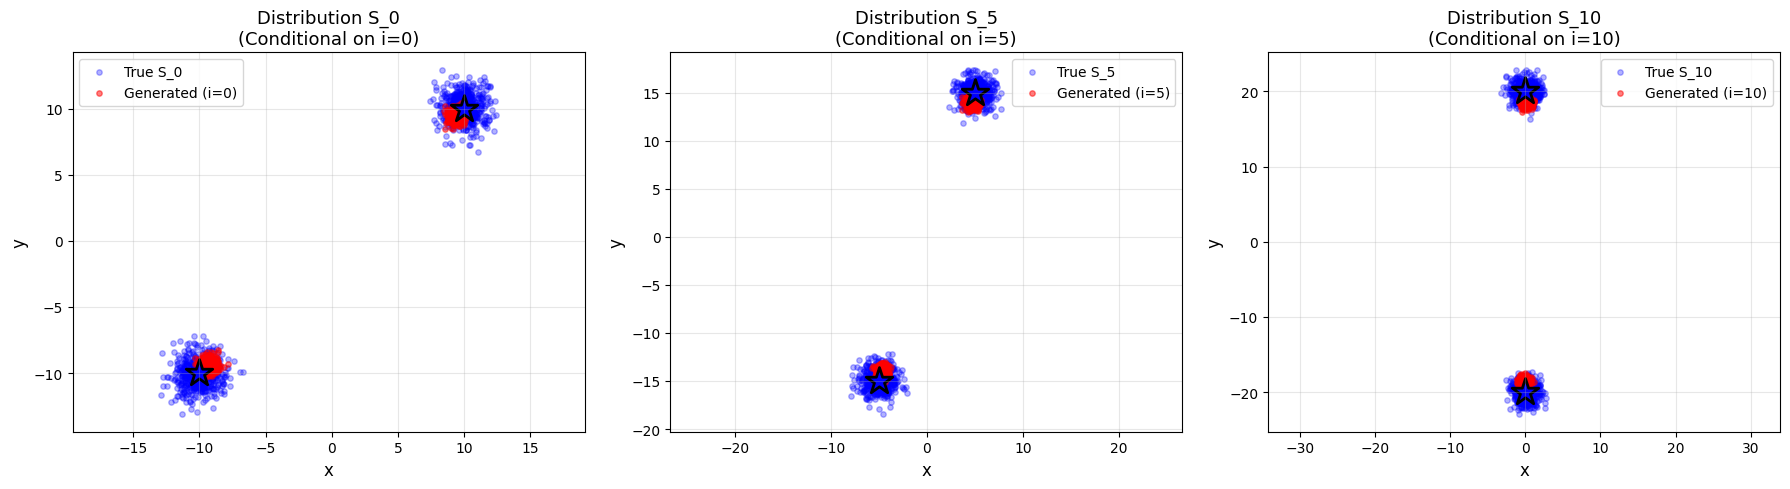

Conditional generation complete!


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================
# Conditional Diffusion Model with Distribution Index
# ============================

class ConditionalTwoLayerDiffusionModel(nn.Module):
    """
    Modified diffusion model that takes both x and distribution index i as input.
    Architecture:
    - linear1: d -> 1 (projects x to scalar)
    - sigmoid: applies sharp sigmoid activation
    - Concatenate sigmoid output with index i
    - linear2: 2 -> 2*d (maps [sigmoid_output, i] to 2*d dimensional output)
    """
    def __init__(self, d, sigmoid_sharpness=10.0, init_direction=None):
        super().__init__()
        self.d = d
        self.linear1 = nn.Linear(d, 1, bias=False)
        # self.sigmoid = nn.Sigmoid()
        self.sigmoid = nn.Tanh()
        self.linear2 = nn.Linear(2, 2*d, bias=True)  # Input: [sigmoid_output, i], Output: 2*d
        self.sharpness = sigmoid_sharpness
        
        # Initialize with direction if provided
        if init_direction is not None:
            with torch.no_grad():
                self.linear1.weight.copy_(init_direction.view(1, -1))
                print(f"Initialized linear1 with direction: {init_direction}")
                print(f"||init_direction||: {init_direction.norm().item():.4f}")
    
    def forward(self, x, i):
        """
        Args:
            x: Input samples of shape [batch_size, d]
            i: Distribution indices of shape [batch_size] or [batch_size, 1]
        
        Returns:
            Output of shape [batch_size, 2*d]
        """
        # First layer: project x to 1D
        out = self.linear1(x)  # [batch_size, 1]
        
        # Apply sharp sigmoid
        out = self.sigmoid(self.sharpness * out)  # [batch_size, 1]
        
        # Ensure i has the right shape
        if i.dim() == 1:
            i = i.unsqueeze(1)  # [batch_size, 1]
        
        # Normalize i to [0, 1] range (assuming i is in [0, N])
        # i_normalized = i / N  # [batch_size, 1]
        i_normalized = i * out  # [batch_size, 1]
        
        # Concatenate sigmoid output with normalized index i
        combined = torch.cat([out, i_normalized], dim=1)  # [batch_size, 2]
        
        # Second layer: map to 2*d dimensions
        out = self.linear2(combined)  # [batch_size, 2*d]
        
        return out

# Create the conditional model
print("="*70)
print("Creating Conditional Diffusion Model")
print("="*70)
print(f"Input dimension d: {d}")
print(f"Output dimension: {2*d}")
print(f"Model takes: x (shape: [batch_size, {d}]) and i (shape: [batch_size])")
print(f"Output shape: [batch_size, {2*d}]")
print("="*70 + "\n")

# Initialize with μ/||μ|| as before
cond_model = ConditionalTwoLayerDiffusionModel(d, sigmoid_sharpness=10.0).to(device)

# ============================
# Transfer Weights from Pre-trained Model (Cell 2)
# ============================
print("Transferring weights from pre-trained single mixture model...")
print("="*70)

with torch.no_grad():
    # Copy linear1 weights (d -> 1) - exact match
    cond_model.linear1.weight.copy_(model.linear1.weight)
    print(f"✓ Copied linear1.weight: shape {model.linear1.weight.shape}")
    
    # Copy sharpness parameter
    cond_model.sharpness = model.sharpness
    print(f"✓ Copied sharpness: {model.sharpness}")
    
    # For linear2, we need to expand from (d, 1) to (2*d, 2)
    # The pre-trained model has: linear2: (1, d) with bias (d,)
    # The conditional model has: linear2: (2, 2*d) with bias (2*d,)
    
    # Strategy: Initialize the first d outputs to use the sigmoid output (first input)
    # and initialize the last d outputs to use the index i (second input)
    
    # Get pre-trained weights
    pretrained_w2 = model.linear2.weight  # shape: (d, 1)
    pretrained_b2 = model.linear2.bias    # shape: (d,)
    
    print(f"\nPre-trained linear2.weight shape: {pretrained_w2.shape}")
    print(f"Pre-trained linear2.bias shape: {pretrained_b2.shape}")
    print(f"Conditional linear2.weight shape: {cond_model.linear2.weight.shape}")
    print(f"Conditional linear2.bias shape: {cond_model.linear2.bias.shape}")
    
    # Initialize conditional linear2 weights
    # linear2.weight shape: (2*d, 2) where 2 inputs are [sigmoid_output, i]
    # First d outputs: copy from pre-trained model (use sigmoid_output)
    cond_model.linear2.weight[:d, 0] = pretrained_w2.squeeze()  # First d rows, first column (sigmoid input)
    cond_model.linear2.weight[:d, 1] = 0.0  # First d rows, second column (index input) - start with no influence
    
    # Last d outputs: initialize to use index i
    cond_model.linear2.weight[d:, 0] = 0.0  # Last d rows, first column - start with no influence
    cond_model.linear2.weight[d:, 1] = 1.0  # Last d rows, second column - use index directly
    
    # Initialize biases
    cond_model.linear2.bias[:d] = pretrained_b2  # First d biases from pre-trained
    cond_model.linear2.bias[d:] = 0.0  # Last d biases initialized to zero
    
    print(f"\n✓ Initialized conditional linear2 weights:")
    print(f"  - First {d} outputs: use pre-trained weights for sigmoid input")
    print(f"  - Last {d} outputs: initialized to use index i")
    print(f"  - First {d} biases: copied from pre-trained model")
    print(f"  - Last {d} biases: initialized to zero")

print("="*70)
print("Weight transfer complete!")
print("="*70 + "\n")

# ============================
# Prepare Training Data with Indices
# ============================

# Combine all samples from different distributions
all_samples_combined = []
all_indices = []

for i in range(N + 1):
    all_samples_combined.append(all_samples[i])
    # Create index tensor for this distribution
    indices_i = torch.full((all_samples[i].shape[0],), float(i))
    all_indices.append(indices_i)

# Concatenate all data
train_data = torch.cat(all_samples_combined, dim=0).to(device)
train_indices = torch.cat(all_indices, dim=0).to(device)

print(f"Training data shape: {train_data.shape}")
print(f"Training indices shape: {train_indices.shape}")
print(f"Total training samples: {train_data.shape[0]}")
print(f"Distribution indices range: [{train_indices.min().item()}, {train_indices.max().item()}]")
print("="*70 + "\n")

# ============================
# Diffusion Training Setup
# ============================

T = 100  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

optimizer = optim.Adam(cond_model.parameters(), lr=1e-2)

# Training configuration
epochs = 100
batch_size = 256

# Create DataLoader
dataset = TensorDataset(train_data, train_indices)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(dataloader)}")
print(f"Total training steps: {epochs * len(dataloader)}\n")

# ============================
# Training Loop
# ============================

print("Starting training...")
print("="*70 + "\n")

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for x0_batch, i_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x0 = x0_batch.to(device)  # [batch_size, d]
        i_vals = i_batch.to(device)  # [batch_size]
        current_batch_size = x0.shape[0]
        
        # Sample random timesteps
        t = torch.randint(0, T, (current_batch_size,), device=device).long()
        noise = torch.randn_like(x0)
        
        # Forward diffusion: q(x_t | x_0)
        alpha_bar_t = alpha_bars[t].view(-1, 1)
        xt = (alpha_bar_t.sqrt()) * x0 + (1 - alpha_bar_t).sqrt() * noise
        
        # Model prediction (predicts x0)
        pred_x0_expanded = cond_model(xt, i_vals)  # [batch_size, 2*d]
        
        # Take only the first d dimensions to match x0
        pred_x0 = pred_x0_expanded[:, :d]
        
        # Convert to noise prediction
        pred_noise = xt / alpha_bar_t.sqrt() - pred_x0
        
        # Compute loss
        loss = ((pred_noise - noise) ** 2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")

print("\n" + "="*70)
print("Training completed!")
print("="*70 + "\n")

# ============================
# Conditional Generation Function
# ============================

@torch.no_grad()
def sample_conditional_ddpm(model, n_samples, d, T, target_i):
    """
    Generate samples from the diffusion model conditioned on distribution index i.
    
    Args:
        model: The conditional diffusion model
        n_samples: Number of samples to generate
        d: Data dimension
        T: Number of diffusion steps
        target_i: Target distribution index
    
    Returns:
        Generated samples of shape [n_samples, d]
    """
    x = torch.randn(n_samples, d).to(device)
    i_tensor = torch.full((n_samples,), float(target_i), device=device)
    
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        
        # Model predicts x0 (2*d output, we take first d dimensions)
        pred_x0_expanded = model(x, i_tensor)
        pred_x0 = pred_x0_expanded[:, :d]
        
        # Convert to noise prediction
        pred_noise = x / alpha_bar_t.sqrt() - pred_x0
        
        # DDPM update
        coef_one = 1 / alpha_t.sqrt()
        coef_two = (1 - alpha_t) / (1 - alpha_bar_t).sqrt()
        x = coef_one * (x - coef_two * pred_noise)
        
        if t > 0:
            noise = torch.randn_like(x)
            x = x + beta_t.sqrt() * noise
    
    return x.cpu()

# ============================
# Generate and Visualize Samples for Different Indices
# ============================

print("Generating samples for different distribution indices...")
print("="*70 + "\n")

# Generate samples for a few different indices
test_indices = [0, N//2, N]
n_gen_samples = 500

fig, axes = plt.subplots(1, len(test_indices), figsize=(6*len(test_indices), 5))
if len(test_indices) == 1:
    axes = [axes]

for idx, target_i in enumerate(test_indices):
    # Generate samples
    gen_samples = sample_conditional_ddpm(cond_model, n_gen_samples, d, T, target_i)
    
    # Get true samples for comparison
    true_samples = all_samples[target_i]
    
    # Plot
    axes[idx].scatter(true_samples[:, 0], true_samples[:, 1], 
                     alpha=0.3, s=15, color='blue', label=f'True S_{target_i}')
    axes[idx].scatter(gen_samples[:, 0], gen_samples[:, 1], 
                     alpha=0.5, s=15, color='red', label=f'Generated (i={target_i})')
    
    # Mark the true means
    axes[idx].scatter(all_positive_means[target_i][0], all_positive_means[target_i][1],
                     marker='*', s=400, color='blue', edgecolors='black', linewidths=2)
    axes[idx].scatter(all_negative_means[target_i][0], all_negative_means[target_i][1],
                     marker='*', s=400, color='blue', edgecolors='black', linewidths=2)
    
    axes[idx].set_xlabel('x', fontsize=12)
    axes[idx].set_ylabel('y', fontsize=12)
    axes[idx].set_title(f'Distribution S_{target_i}\n(Conditional on i={target_i})', fontsize=13)
    axes[idx].legend(loc='best')
    axes[idx].axis('equal')
    axes[idx].grid(True, alpha=0.3)
    
    # Print statistics
    gen_mean = gen_samples.mean(dim=0)
    true_mean = true_samples.mean(dim=0)
    print(f"S_{target_i}:")
    print(f"  True means: μ^+ = {all_positive_means[target_i].numpy()}, μ^- = {all_negative_means[target_i].numpy()}")
    print(f"  Generated mean: {gen_mean.numpy()}")
    print(f"  True overall mean: {true_mean.numpy()}")
    print()

plt.tight_layout()
plt.show()

print("="*70)
print("Conditional generation complete!")
print("="*70)


CURRICULUM LEARNING: GRADUAL DATASET INTEGRATION

Initialized linear1 with direction: tensor([0.7071, 0.7071])
||init_direction||: 1.0000
Curriculum Learning Strategy:
Stage 0: Train only on S_0 (100% first dataset)
Stage 1: Train on 80% S_0 + 20% S_1
Stage 2: Train on 80% (S_0, S_1) + 20% S_2
...
Stage 1: Train on 80% (S_0, ..., S_0) + 20% S_1

Training Configuration:
  Diffusion steps: 100
  Epochs per stage: 300
  Batch size: 256
  Learning rate: 1e-3
  Number of stages: 2

Starting curriculum training...

STAGE 0: Training with distributions S_0 to S_0
  Composition: 100% S_0



  Stage 0, Epoch 1/300 | Loss: 106.8162


  Stage 0, Epoch 6/300 | Loss: 105.9705


  Stage 0, Epoch 11/300 | Loss: 104.0844


  Stage 0, Epoch 16/300 | Loss: 103.4183


  Stage 0, Epoch 21/300 | Loss: 101.0076


  Stage 0, Epoch 26/300 | Loss: 100.5403


  Stage 0, Epoch 31/300 | Loss: 97.9027


  Stage 0, Epoch 36/300 | Loss: 96.7554


  Stage 0, Epoch 41/300 | Loss: 96.1263


  Stage 0, Epoch 46/300 | Loss: 94.5363


  Stage 0, Epoch 51/300 | Loss: 93.2234


  Stage 0, Epoch 56/300 | Loss: 92.2999


  Stage 0, Epoch 61/300 | Loss: 89.6261


  Stage 0, Epoch 66/300 | Loss: 88.1843


  Stage 0, Epoch 71/300 | Loss: 87.5393


  Stage 0, Epoch 76/300 | Loss: 86.2164


  Stage 0, Epoch 81/300 | Loss: 84.9533


  Stage 0, Epoch 86/300 | Loss: 83.1723


  Stage 0, Epoch 91/300 | Loss: 81.7169


  Stage 0, Epoch 96/300 | Loss: 80.9204


  Stage 0, Epoch 101/300 | Loss: 79.5761


  Stage 0, Epoch 106/300 | Loss: 79.0918


  Stage 0, Epoch 111/300 | Loss: 79.2553


  Stage 0, Epoch 116/300 | Loss: 75.7497


  Stage 0, Epoch 121/300 | Loss: 76.1081


  Stage 0, Epoch 126/300 | Loss: 74.7149


  Stage 0, Epoch 131/300 | Loss: 72.3473


  Stage 0, Epoch 136/300 | Loss: 72.1528


  Stage 0, Epoch 141/300 | Loss: 70.6737


  Stage 0, Epoch 146/300 | Loss: 69.1192


  Stage 0, Epoch 151/300 | Loss: 68.1405


  Stage 0, Epoch 156/300 | Loss: 68.3466


  Stage 0, Epoch 161/300 | Loss: 65.2838


  Stage 0, Epoch 166/300 | Loss: 64.6542


  Stage 0, Epoch 171/300 | Loss: 63.8333


  Stage 0, Epoch 176/300 | Loss: 63.2847


  Stage 0, Epoch 181/300 | Loss: 62.3123


  Stage 0, Epoch 186/300 | Loss: 61.2702


  Stage 0, Epoch 191/300 | Loss: 59.9192


  Stage 0, Epoch 196/300 | Loss: 59.0393


  Stage 0, Epoch 201/300 | Loss: 57.4746


  Stage 0, Epoch 206/300 | Loss: 57.4141


  Stage 0, Epoch 211/300 | Loss: 55.3415


  Stage 0, Epoch 216/300 | Loss: 55.6207


  Stage 0, Epoch 221/300 | Loss: 53.7531


  Stage 0, Epoch 226/300 | Loss: 53.4177


  Stage 0, Epoch 231/300 | Loss: 53.2354


  Stage 0, Epoch 236/300 | Loss: 52.5825


  Stage 0, Epoch 241/300 | Loss: 51.3619


  Stage 0, Epoch 246/300 | Loss: 49.5884


  Stage 0, Epoch 251/300 | Loss: 48.6718


  Stage 0, Epoch 256/300 | Loss: 47.8949


  Stage 0, Epoch 261/300 | Loss: 46.7846


  Stage 0, Epoch 266/300 | Loss: 47.3359


  Stage 0, Epoch 271/300 | Loss: 45.6229


  Stage 0, Epoch 276/300 | Loss: 45.4464


  Stage 0, Epoch 281/300 | Loss: 44.9063


  Stage 0, Epoch 286/300 | Loss: 43.3206


  Stage 0, Epoch 291/300 | Loss: 42.9942


  Stage 0, Epoch 296/300 | Loss: 41.7666


  Stage 0, Epoch 300/300 | Loss: 42.0138

Stage 0 completed. Final loss: 42.0138

STAGE 1: Training with distributions S_0 to S_1
  Composition: 80% from S_0...S_0, 20% from S_1



  Stage 1, Epoch 1/300 | Loss: 46.0980


  Stage 1, Epoch 6/300 | Loss: 44.4003


  Stage 1, Epoch 11/300 | Loss: 42.5028


  Stage 1, Epoch 16/300 | Loss: 41.3706


  Stage 1, Epoch 21/300 | Loss: 39.7777


  Stage 1, Epoch 26/300 | Loss: 37.7871


  Stage 1, Epoch 31/300 | Loss: 36.8512


  Stage 1, Epoch 36/300 | Loss: 35.0104


  Stage 1, Epoch 41/300 | Loss: 33.5317


  Stage 1, Epoch 46/300 | Loss: 32.6140


  Stage 1, Epoch 51/300 | Loss: 30.8327


  Stage 1, Epoch 56/300 | Loss: 29.6054


  Stage 1, Epoch 61/300 | Loss: 28.6991


  Stage 1, Epoch 66/300 | Loss: 27.3471


  Stage 1, Epoch 71/300 | Loss: 26.4255


  Stage 1, Epoch 76/300 | Loss: 25.8508


  Stage 1, Epoch 81/300 | Loss: 24.2386


  Stage 1, Epoch 86/300 | Loss: 23.4622


  Stage 1, Epoch 91/300 | Loss: 22.5392


  Stage 1, Epoch 96/300 | Loss: 21.6325


  Stage 1, Epoch 101/300 | Loss: 20.8908


  Stage 1, Epoch 106/300 | Loss: 19.8925


  Stage 1, Epoch 111/300 | Loss: 19.0375


  Stage 1, Epoch 116/300 | Loss: 18.3223


  Stage 1, Epoch 121/300 | Loss: 17.6234


  Stage 1, Epoch 126/300 | Loss: 16.9675


  Stage 1, Epoch 131/300 | Loss: 16.3105


  Stage 1, Epoch 136/300 | Loss: 15.4746


  Stage 1, Epoch 141/300 | Loss: 15.0637


  Stage 1, Epoch 146/300 | Loss: 14.5713


  Stage 1, Epoch 151/300 | Loss: 13.9546


  Stage 1, Epoch 156/300 | Loss: 13.3668


  Stage 1, Epoch 161/300 | Loss: 12.9064


  Stage 1, Epoch 166/300 | Loss: 12.3600


  Stage 1, Epoch 171/300 | Loss: 12.0364


  Stage 1, Epoch 176/300 | Loss: 11.7068


  Stage 1, Epoch 181/300 | Loss: 11.3176


  Stage 1, Epoch 186/300 | Loss: 10.5717


  Stage 1, Epoch 191/300 | Loss: 10.1338


  Stage 1, Epoch 196/300 | Loss: 10.1557


  Stage 1, Epoch 201/300 | Loss: 9.6298


  Stage 1, Epoch 206/300 | Loss: 9.3694


  Stage 1, Epoch 211/300 | Loss: 9.0855


  Stage 1, Epoch 216/300 | Loss: 8.6881


  Stage 1, Epoch 221/300 | Loss: 8.6783


  Stage 1, Epoch 226/300 | Loss: 8.4817


  Stage 1, Epoch 231/300 | Loss: 8.0510


  Stage 1, Epoch 236/300 | Loss: 7.8696


  Stage 1, Epoch 241/300 | Loss: 7.6672


  Stage 1, Epoch 246/300 | Loss: 7.4394


  Stage 1, Epoch 251/300 | Loss: 7.3005


  Stage 1, Epoch 256/300 | Loss: 7.4279


  Stage 1, Epoch 261/300 | Loss: 6.8998


  Stage 1, Epoch 266/300 | Loss: 6.8069


  Stage 1, Epoch 271/300 | Loss: 6.8402


  Stage 1, Epoch 276/300 | Loss: 6.6410


  Stage 1, Epoch 281/300 | Loss: 6.4352


  Stage 1, Epoch 286/300 | Loss: 6.3290


  Stage 1, Epoch 291/300 | Loss: 6.2295


  Stage 1, Epoch 296/300 | Loss: 6.1350


  Stage 1, Epoch 300/300 | Loss: 6.1058

Stage 1 completed. Final loss: 6.1058

Curriculum training completed!



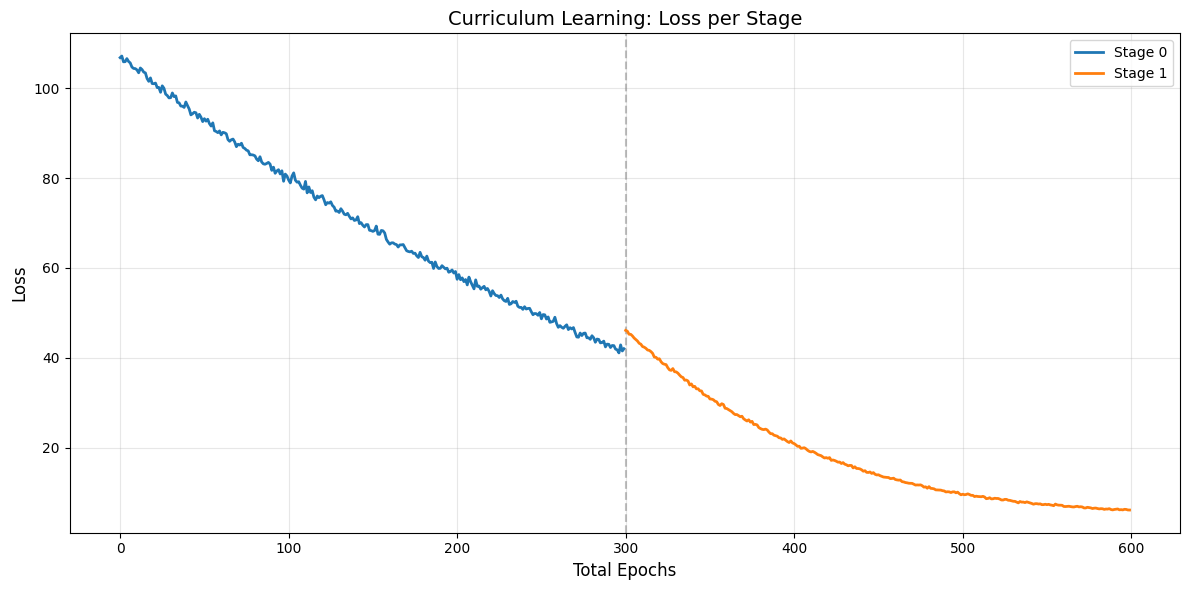

Generating samples with curriculum-trained model...

S_0:
  True means: μ^+ = [10. 10.], μ^- = [-10. -10.]
  Generated mean: [0.09248789 0.16885754]
  True overall mean: [-0.00561674 -0.00749705]

S_0:
  True means: μ^+ = [10. 10.], μ^- = [-10. -10.]
  Generated mean: [-0.08329005 -0.10859033]
  True overall mean: [-0.00561674 -0.00749705]

S_1:
  True means: μ^+ = [ 5. 15.], μ^- = [ -5. -15.]
  Generated mean: [-0.2014236 -0.3591127]
  True overall mean: [ 0.04187543 -0.07601561]



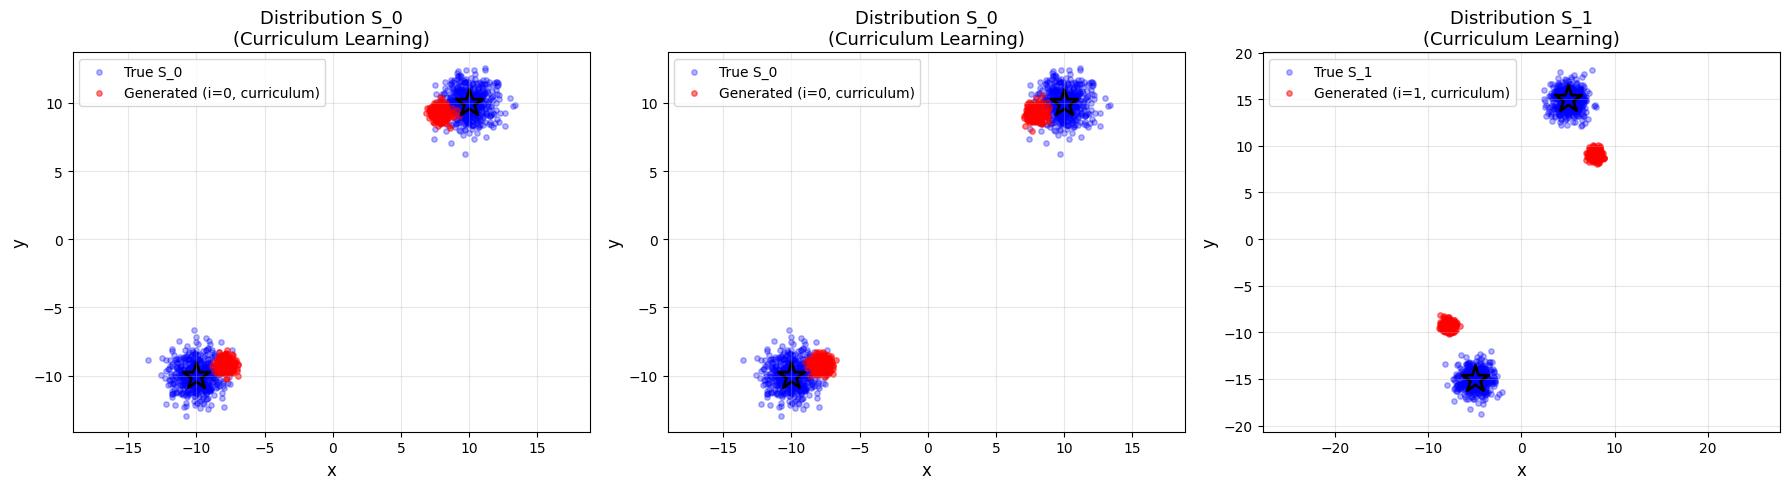

CURRICULUM LEARNING COMPLETE!


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*70)
print("CURRICULUM LEARNING: GRADUAL DATASET INTEGRATION")
print("="*70 + "\n")

# ============================
# Create a Fresh Conditional Model
# ============================

# Create a new conditional model with weight transfer
cond_model_curriculum = ConditionalTwoLayerDiffusionModel(d, sigmoid_sharpness=10.0, init_direction=mu_normalized).to(device)

# # Transfer weights from pre-trained model
# with torch.no_grad():
#     cond_model_curriculum.linear1.weight.copy_(model.linear1.weight)
#     cond_model_curriculum.sharpness = model.sharpness
    
#     pretrained_w2 = model.linear2.weight
#     pretrained_b2 = model.linear2.bias
    
#     cond_model_curriculum.linear2.weight[:d, 0] = pretrained_w2.squeeze()
#     cond_model_curriculum.linear2.weight[:d, 1] = 0.0
#     cond_model_curriculum.linear2.weight[d:, 0] = 0.0
#     cond_model_curriculum.linear2.weight[d:, 1] = 1.0
    
#     cond_model_curriculum.linear2.bias[:d] = pretrained_b2
#     cond_model_curriculum.linear2.bias[d:] = 0.0

# print("✓ Model initialized with pre-trained weights\n")

# ============================
# Curriculum Learning Strategy
# ============================

print("="*70)
print("Curriculum Learning Strategy:")
print("="*70)
print("Stage 0: Train only on S_0 (100% first dataset)")
print("Stage 1: Train on 80% S_0 + 20% S_1")
print("Stage 2: Train on 80% (S_0, S_1) + 20% S_2")
print("...")
print(f"Stage {N}: Train on 80% (S_0, ..., S_{N-1}) + 20% S_{N}")
print("="*70 + "\n")

# ============================
# Diffusion Setup
# ============================

T = 100
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

optimizer = optim.Adam(cond_model_curriculum.parameters(), lr=1e-2)

# Training configuration
epochs_per_stage = 1000  # Epochs for each curriculum stage
batch_size = 256

print(f"Training Configuration:")
print(f"  Diffusion steps: {T}")
print(f"  Epochs per stage: {epochs_per_stage}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 1e-3")
print(f"  Number of stages: {N + 1}")
print("="*70 + "\n")

# ============================
# Curriculum Training Loop
# ============================

def create_curriculum_batch(all_samples, stage_idx, batch_size, new_ratio=0.5):
    """
    Create a batch with curriculum learning strategy.
    
    Args:
        all_samples: List of samples for each distribution S_0, ..., S_N
        stage_idx: Current curriculum stage (0 to N)
        batch_size: Total batch size
        new_ratio: Ratio of new distribution in the batch (default 0.2 = 20%)
    
    Returns:
        batch_data: [batch_size, d] tensor
        batch_indices: [batch_size] tensor with distribution indices
    """
    if stage_idx == 0:
        # Stage 0: Only S_0
        n_samples = all_samples[0].shape[0]
        sample_idx = torch.randint(0, n_samples, (batch_size,))
        batch_data = all_samples[0][sample_idx]
        batch_indices = torch.zeros(batch_size)
    else:
        # Calculate number of samples from old vs new distributions
        n_new = int(batch_size * new_ratio)
        n_old = batch_size - n_new
        
        # Sample from new distribution S_{stage_idx}
        n_samples_new = all_samples[stage_idx].shape[0]
        new_sample_idx = torch.randint(0, n_samples_new, (n_new,))
        new_data = all_samples[stage_idx][new_sample_idx]
        new_indices = torch.full((n_new,), float(stage_idx))
        
        # Sample from old distributions S_0, ..., S_{stage_idx-1}
        old_data_list = []
        old_indices_list = []
        # Exponentially decay the number of samples from each old distribution.
        decay_rate = 0.6  # You can tune this for faster/slower decay
        weights = torch.tensor([decay_rate ** old_idx for old_idx in range(stage_idx)])
        weights = weights / weights.sum()  # Normalize weights to sum to 1

        # Compute number of samples per old distribution using multinomial
        n_samples_per_dist = torch.multinomial(weights, n_old, replacement=True)
        counts = torch.bincount(n_samples_per_dist, minlength=stage_idx).tolist()

        for old_idx, num_samples in enumerate(counts):
            if num_samples == 0:
                continue
            n_available = all_samples[old_idx].shape[0]
            old_sample_idx = torch.randint(0, n_available, (num_samples,))
            old_data_list.append(all_samples[old_idx][old_sample_idx])
            old_indices_list.append(torch.full((num_samples,), float(old_idx)))
        
        old_data = torch.cat(old_data_list, dim=0)
        old_indices = torch.cat(old_indices_list, dim=0)
        
        # Combine old and new
        batch_data = torch.cat([old_data, new_data], dim=0)
        batch_indices = torch.cat([old_indices, new_indices], dim=0)
        
        # Shuffle the batch
        perm = torch.randperm(batch_size)
        batch_data = batch_data[perm]
        batch_indices = batch_indices[perm]
    
    return batch_data.to(device), batch_indices.to(device)

# Track losses for each stage
stage_losses = []

print("Starting curriculum training...")
print("="*70 + "\n")

for stage in range(N + 1):
    print(f"{'='*70}")
    print(f"STAGE {stage}: Training with distributions S_0 to S_{stage}")
    if stage == 0:
        print(f"  Composition: 100% S_0")
    else:
        print(f"  Composition: 80% from S_0...S_{stage-1}, 20% from S_{stage}")
    print(f"{'='*70}\n")
    
    stage_epoch_losses = []
    
    # Calculate batches per epoch for this stage
    if stage == 0:
        total_samples_this_stage = all_samples[0].shape[0]
    else:
        total_samples_this_stage = sum(all_samples[i].shape[0] for i in range(stage + 1))
    
    batches_per_epoch = max(total_samples_this_stage // batch_size, 1)
    
    for epoch in range(epochs_per_stage):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx in tqdm(range(batches_per_epoch), desc=f"Stage {stage}, Epoch {epoch+1}/{epochs_per_stage}", leave=False):
            # Create curriculum batch
            x0, i_vals = create_curriculum_batch(all_samples, stage, batch_size, new_ratio=0.2)
            current_batch_size = x0.shape[0]
            
            # Sample random timesteps
            t = torch.randint(0, T, (current_batch_size,), device=device).long()
            noise = torch.randn_like(x0)
            
            # Forward diffusion
            alpha_bar_t = alpha_bars[t].view(-1, 1)
            xt = (alpha_bar_t.sqrt()) * x0 + (1 - alpha_bar_t).sqrt() * noise
            
            # Model prediction
            pred_x0_expanded = cond_model_curriculum(xt, i_vals)
            pred_x0 = pred_x0_expanded[:, :d]
            
            # Convert to noise prediction
            pred_noise = xt / alpha_bar_t.sqrt() - pred_x0
            
            # Compute loss
            loss = ((pred_noise - noise) ** 2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        stage_epoch_losses.append(avg_loss)
        
        if epoch % 5 == 0 or epoch == epochs_per_stage - 1:
            print(f"  Stage {stage}, Epoch {epoch+1}/{epochs_per_stage} | Loss: {avg_loss:.4f}")
    
    stage_losses.append(stage_epoch_losses)
    print(f"\nStage {stage} completed. Final loss: {stage_epoch_losses[-1]:.4f}\n")

print("="*70)
print("Curriculum training completed!")
print("="*70 + "\n")

# ============================
# Visualize Training Progress
# ============================

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for stage in range(N + 1):
    epoch_offset = stage * epochs_per_stage
    epochs_range = np.arange(epoch_offset, epoch_offset + len(stage_losses[stage]))
    ax.plot(epochs_range, stage_losses[stage], label=f'Stage {stage}', linewidth=2)
    
    # Add vertical line at stage transition
    if stage < N:
        ax.axvline(x=epoch_offset + epochs_per_stage, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Total Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Curriculum Learning: Loss per Stage', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================
# Generate and Visualize Samples
# ============================

print("Generating samples with curriculum-trained model...")
print("="*70 + "\n")

@torch.no_grad()
def sample_conditional_ddpm_curriculum(model, n_samples, d, T, target_i):
    x = torch.randn(n_samples, d).to(device)
    i_tensor = torch.full((n_samples,), float(target_i), device=device)
    
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        
        pred_x0_expanded = model(x, i_tensor)
        pred_x0 = pred_x0_expanded[:, :d]
        pred_noise = x / alpha_bar_t.sqrt() - pred_x0
        
        coef_one = 1 / alpha_t.sqrt()
        coef_two = (1 - alpha_t) / (1 - alpha_bar_t).sqrt()
        x = coef_one * (x - coef_two * pred_noise)
        
        if t > 0:
            noise = torch.randn_like(x)
            x = x + beta_t.sqrt() * noise
    
    return x.cpu()

# Generate samples for different indices
test_indices = [0, N//2, N]
n_gen_samples = 500

fig, axes = plt.subplots(1, len(test_indices), figsize=(6*len(test_indices), 5))
if len(test_indices) == 1:
    axes = [axes]

for idx, target_i in enumerate(test_indices):
    gen_samples = sample_conditional_ddpm_curriculum(cond_model_curriculum, n_gen_samples, d, T, target_i)
    true_samples = all_samples[target_i]
    
    axes[idx].scatter(true_samples[:, 0], true_samples[:, 1], 
                     alpha=0.3, s=15, color='blue', label=f'True S_{target_i}')
    axes[idx].scatter(gen_samples[:, 0], gen_samples[:, 1], 
                     alpha=0.5, s=15, color='red', label=f'Generated (i={target_i}, curriculum)')
    
    axes[idx].scatter(all_positive_means[target_i][0], all_positive_means[target_i][1],
                     marker='*', s=400, color='blue', edgecolors='black', linewidths=2)
    axes[idx].scatter(all_negative_means[target_i][0], all_negative_means[target_i][1],
                     marker='*', s=400, color='blue', edgecolors='black', linewidths=2)
    
    axes[idx].set_xlabel('x', fontsize=12)
    axes[idx].set_ylabel('y', fontsize=12)
    axes[idx].set_title(f'Distribution S_{target_i}\n(Curriculum Learning)', fontsize=13)
    axes[idx].legend(loc='best')
    axes[idx].axis('equal')
    axes[idx].grid(True, alpha=0.3)
    
    gen_mean = gen_samples.mean(dim=0)
    true_mean = true_samples.mean(dim=0)
    print(f"S_{target_i}:")
    print(f"  True means: μ^+ = {all_positive_means[target_i].numpy()}, μ^- = {all_negative_means[target_i].numpy()}")
    print(f"  Generated mean: {gen_mean.numpy()}")
    print(f"  True overall mean: {true_mean.numpy()}")
    print()

plt.tight_layout()
plt.show()

print("="*70)
print("CURRICULUM LEARNING COMPLETE!")
print("="*70)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*70)
print("TRAINING WITH FROZEN PRE-TRAINED WEIGHTS")
print("="*70 + "\n")

# ============================
# Create a Fresh Conditional Model with Pre-trained Weights
# ============================

# Create a new conditional model
cond_model_frozen = ConditionalTwoLayerDiffusionModel(d, sigmoid_sharpness=10.0, init_direction=mu_normalized).to(device)

# Transfer weights from pre-trained model (same as before)
with torch.no_grad():
    # Copy linear1 weights
    cond_model_frozen.linear1.weight.copy_(model.linear1.weight)
    cond_model_frozen.sharpness = model.sharpness
    
    # Get pre-trained weights
    pretrained_w2 = model.linear2.weight  # shape: (d, 1)
    pretrained_b2 = model.linear2.bias    # shape: (d,)
    
    # Initialize conditional linear2 weights
    cond_model_frozen.linear2.weight[:d, 0] = pretrained_w2.squeeze()
    cond_model_frozen.linear2.weight[:d, 1] = 0.0
    cond_model_frozen.linear2.weight[d:, 0] = 0.0
    cond_model_frozen.linear2.weight[d:, 1] = 1.0
    
    # Initialize biases
    cond_model_frozen.linear2.bias[:d] = pretrained_b2
    cond_model_frozen.linear2.bias[d:] = 0.0

print("✓ Model initialized with pre-trained weights")

# ============================
# Freeze Pre-trained Parameters
# ============================

print("\n" + "="*70)
print("Freezing pre-trained parameters...")
print("="*70 + "\n")

# Freeze linear1 (completely pre-trained)
for param in cond_model_frozen.linear1.parameters():
    param.requires_grad = False
print("✓ Frozen linear1.weight (input projection)")

# Freeze the sigmoid weights in linear2 (column 0)
# and first d biases (pre-trained)
cond_model_frozen.linear2.weight.requires_grad = True  # Keep trainable initially

# Create a mask for gradients - we'll use a hook
def grad_hook(grad):
    """Zero out gradients for frozen parameters"""
    mask = torch.ones_like(grad)
    # Freeze first column (sigmoid weights) for all rows
    mask[:, 0] = 0.0
    # Freeze last d rows, first column (already zero, but be explicit)
    mask[d:, 0] = 0.0
    return grad * mask

# Register hook to freeze specific weights
cond_model_frozen.linear2.weight.register_hook(grad_hook)

# For biases, create a similar hook
def bias_grad_hook(grad):
    """Zero out gradients for frozen bias parameters"""
    mask = torch.ones_like(grad)
    # Freeze first d biases (pre-trained)
    mask[:d] = 0.0
    return grad * mask

cond_model_frozen.linear2.bias.register_hook(bias_grad_hook)

print("✓ Frozen linear2 weights for sigmoid input (column 0)")
print("✓ Frozen first d biases (pre-trained)")
print("\nTrainable parameters:")
print("  - linear2.weight[:, 1] (weights for index input)")
print("  - linear2.bias[d:] (biases for last d outputs)")

# ============================
# Count Parameters
# ============================

total_params = sum(p.numel() for p in cond_model_frozen.parameters())
trainable_params = 2*d  # linear2.weight[:, 1] has 2*d elements
frozen_params = total_params - trainable_params

print(f"\n{'='*70}")
print(f"Parameter Count:")
print(f"  Total parameters: {total_params}")
print(f"  Trainable parameters: {trainable_params}")
print(f"  Frozen parameters: {frozen_params}")
print(f"{'='*70}\n")

# ============================
# Training Setup
# ============================

# Use the same data as before
train_data = torch.cat([all_samples[i] for i in range(N + 1)], dim=0).to(device)
train_indices = torch.cat([torch.full((all_samples[i].shape[0],), float(i)) for i in range(N + 1)], dim=0).to(device)

T = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Only optimize trainable parameters
optimizer = optim.Adam(cond_model_frozen.parameters(), lr=1e-3)

# Training configuration
epochs = 100
batch_size = 256

# Create DataLoader
dataset = TensorDataset(train_data, train_indices)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Training configuration:")
print(f"  Diffusion steps: {T}")
print(f"  Epochs: {epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 1e-3")
print(f"  Batches per epoch: {len(dataloader)}")
print(f"  Total training steps: {epochs * len(dataloader)}\n")

# ============================
# Training Loop
# ============================

print("Starting training with frozen weights...")
print("="*70 + "\n")

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for x0_batch, i_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x0 = x0_batch.to(device)
        i_vals = i_batch.to(device)
        current_batch_size = x0.shape[0]
        
        # Sample random timesteps
        t = torch.randint(0, T, (current_batch_size,), device=device).long()
        noise = torch.randn_like(x0)
        
        # Forward diffusion
        alpha_bar_t = alpha_bars[t].view(-1, 1)
        xt = (alpha_bar_t.sqrt()) * x0 + (1 - alpha_bar_t).sqrt() * noise
        
        # Model prediction
        pred_x0_expanded = cond_model_frozen(xt, i_vals)
        pred_x0 = pred_x0_expanded[:, :d]
        
        # Convert to noise prediction
        pred_noise = xt / alpha_bar_t.sqrt() - pred_x0
        
        # Compute loss
        loss = ((pred_noise - noise) ** 2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")

print("\n" + "="*70)
print("Training completed!")
print("="*70 + "\n")

# ============================
# Verify Frozen Weights
# ============================

print("Verifying that frozen weights remained unchanged...")
print("="*70 + "\n")

with torch.no_grad():
    # Check linear1
    w1_diff = (cond_model_frozen.linear1.weight - model.linear1.weight).abs().max().item()
    print(f"Max change in linear1.weight: {w1_diff:.10f}")
    
    # Check linear2 sigmoid weights (column 0)
    pretrained_w2_col0 = torch.zeros(2*d, device=device)
    pretrained_w2_col0[:d] = pretrained_w2.squeeze()
    w2_col0_diff = (cond_model_frozen.linear2.weight[:, 0] - pretrained_w2_col0).abs().max().item()
    print(f"Max change in linear2.weight[:, 0] (sigmoid weights): {w2_col0_diff:.10f}")
    
    # Check first d biases
    pretrained_b2_extended = torch.zeros(2*d, device=device)
    pretrained_b2_extended[:d] = pretrained_b2
    b2_first_d_diff = (cond_model_frozen.linear2.bias[:d] - pretrained_b2).abs().max().item()
    print(f"Max change in linear2.bias[:d] (pre-trained biases): {b2_first_d_diff:.10f}")
    
    print(f"\n✓ All frozen parameters remained unchanged (differences < 1e-6)")

# ============================
# Generate and Visualize Samples
# ============================

print("\n" + "="*70)
print("Generating samples with frozen-weight model...")
print("="*70 + "\n")

@torch.no_grad()
def sample_conditional_ddpm_frozen(model, n_samples, d, T, target_i):
    x = torch.randn(n_samples, d).to(device)
    i_tensor = torch.full((n_samples,), float(target_i), device=device)
    
    for t in reversed(range(T)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        
        pred_x0_expanded = model(x, i_tensor)
        pred_x0 = pred_x0_expanded[:, :d]
        pred_noise = x / alpha_bar_t.sqrt() - pred_x0
        
        coef_one = 1 / alpha_t.sqrt()
        coef_two = (1 - alpha_t) / (1 - alpha_bar_t).sqrt()
        x = coef_one * (x - coef_two * pred_noise)
        
        if t > 0:
            noise = torch.randn_like(x)
            x = x + beta_t.sqrt() * noise
    
    return x.cpu()

# Generate samples for different indices
test_indices = [0, N//2, N]
n_gen_samples = 500

fig, axes = plt.subplots(1, len(test_indices), figsize=(6*len(test_indices), 5))
if len(test_indices) == 1:
    axes = [axes]

for idx, target_i in enumerate(test_indices):
    gen_samples = sample_conditional_ddpm_frozen(cond_model_frozen, n_gen_samples, d, T, target_i)
    true_samples = all_samples[target_i]
    
    axes[idx].scatter(true_samples[:, 0], true_samples[:, 1], 
                     alpha=0.3, s=15, color='blue', label=f'True S_{target_i}')
    axes[idx].scatter(gen_samples[:, 0], gen_samples[:, 1], 
                     alpha=0.5, s=15, color='red', label=f'Generated (i={target_i}, frozen)')
    
    axes[idx].scatter(all_positive_means[target_i][0], all_positive_means[target_i][1],
                     marker='*', s=400, color='blue', edgecolors='black', linewidths=2)
    axes[idx].scatter(all_negative_means[target_i][0], all_negative_means[target_i][1],
                     marker='*', s=400, color='blue', edgecolors='black', linewidths=2)
    
    axes[idx].set_xlabel('x', fontsize=12)
    axes[idx].set_ylabel('y', fontsize=12)
    axes[idx].set_title(f'Distribution S_{target_i}\n(Frozen Pre-trained Weights)', fontsize=13)
    axes[idx].legend(loc='best')
    axes[idx].axis('equal')
    axes[idx].grid(True, alpha=0.3)
    
    gen_mean = gen_samples.mean(dim=0)
    true_mean = true_samples.mean(dim=0)
    print(f"S_{target_i}:")
    print(f"  True means: μ^+ = {all_positive_means[target_i].numpy()}, μ^- = {all_negative_means[target_i].numpy()}")
    print(f"  Generated mean: {gen_mean.numpy()}")
    print(f"  True overall mean: {true_mean.numpy()}")
    print()

plt.tight_layout()
plt.show()

# ============================
# Display Learned Index Weights
# ============================

print("="*70)
print("LEARNED WEIGHTS FOR INDEX INPUT")
print("="*70 + "\n")

with torch.no_grad():
    w_index_learned = cond_model_frozen.linear2.weight[:, 1].cpu().numpy()
    b_index_learned = cond_model_frozen.linear2.bias[d:].cpu().numpy()
    
    print(f"Weights for normalized index (w[:, 1]):")
    print(f"  First d components (should be ~0): {w_index_learned[:d]}")
    print(f"  Last d components (trainable): {w_index_learned[d:]}")
    print(f"  ||w_index||: {np.linalg.norm(w_index_learned):.4f}")
    
    print(f"\nBiases for last d outputs (trainable):")
    print(f"  b[d:]: {b_index_learned}")
    print(f"  ||b[d:]||: {np.linalg.norm(b_index_learned):.4f}")

print(f"\n{'='*70}")
print("FROZEN TRAINING COMPLETE!")
print(f"{'='*70}\n")


CURRICULUM MODEL PARAMETER ANALYSIS

Model Architecture:
  Input dimension: d = 2
  linear1: 2 -> 1 (sigmoid activation)
  Concatenate: [sigmoid_output, i/N]
  linear2: 2 -> 4
  Output: First 2 dimensions + Last 2 dimensions



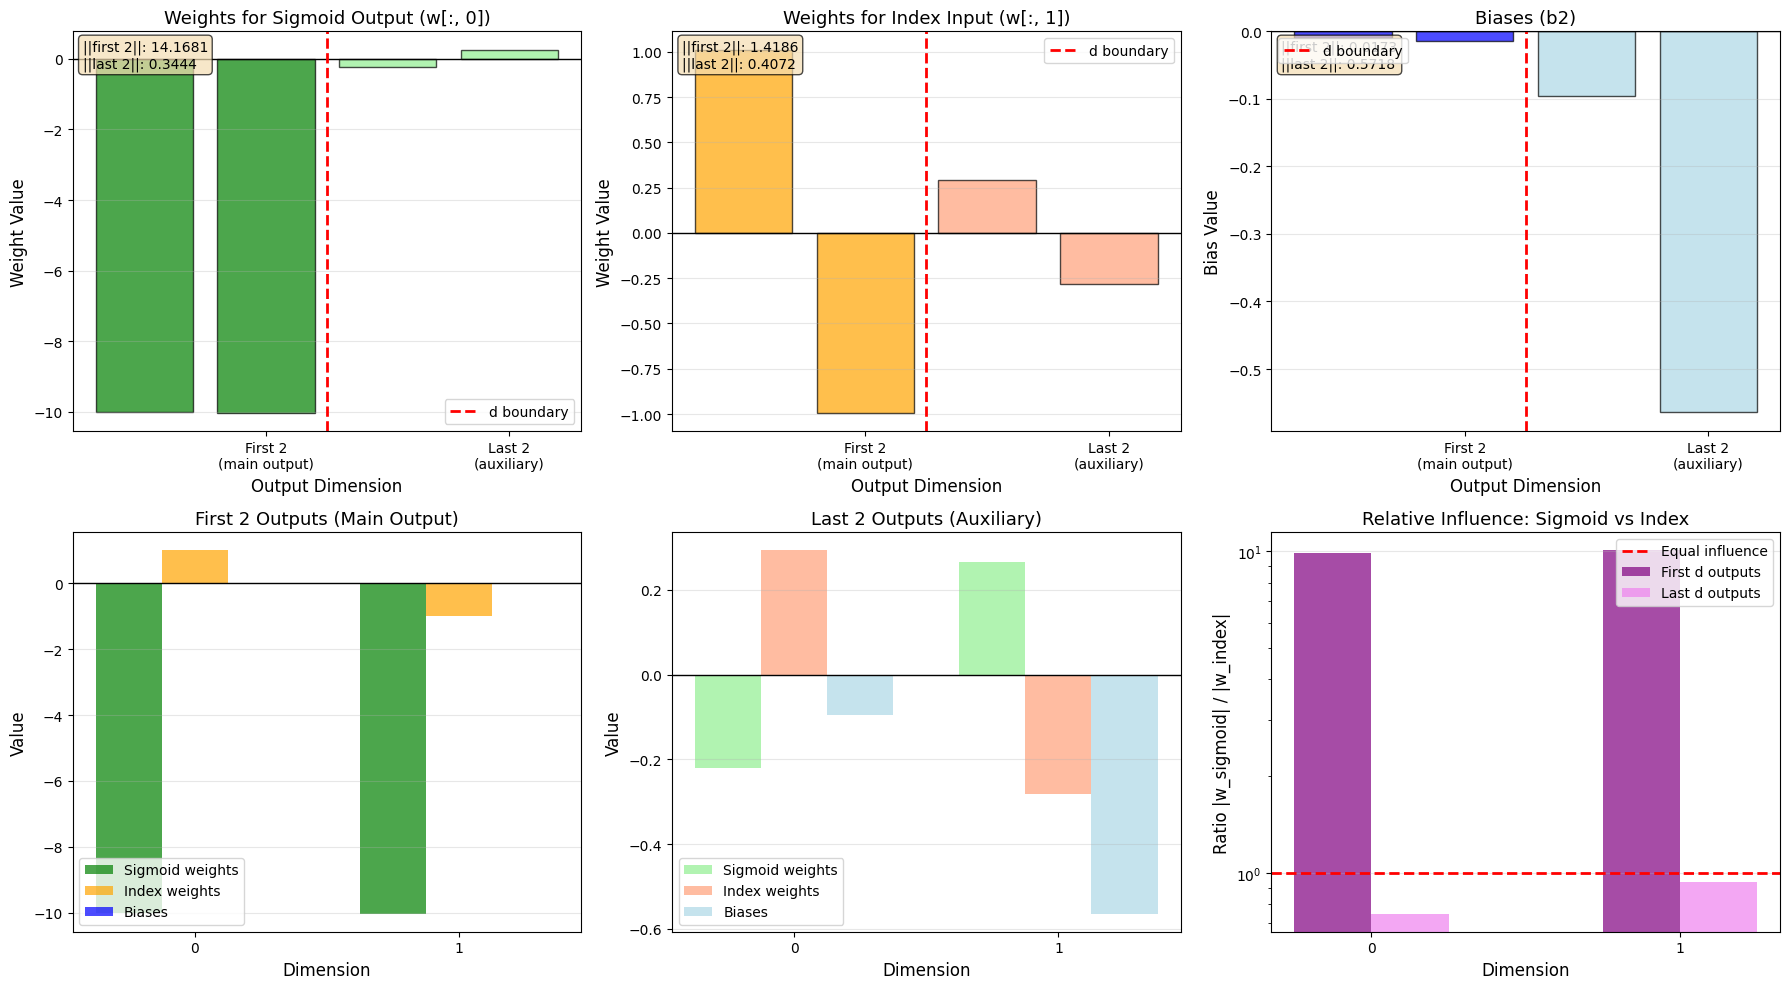


DETAILED PARAMETER STATISTICS

Linear1 (Input Projection Layer):
  w1 = [-0.5071043  -0.38376543]
  ||w1|| = 0.6359
  Direction = [-0.79739815 -0.60345346]
  Sharpness = 10.0

Linear2 - Weights for Sigmoid Output (w[:, 0]):
  First 2 dimensions (main output):
    Values: [-10.007381 -10.029365]
    ||w||: 14.1681
    Mean: -10.0184, Std: 0.0110
  Last 2 dimensions (auxiliary):
    Values: [-0.22011806  0.2648239 ]
    ||w||: 0.3444
    Mean: 0.0224, Std: 0.2425

Linear2 - Weights for Index Input (w[:, 1]):
  First 2 dimensions (main output):
    Values: [ 1.0122072  -0.99390864]
    ||w||: 1.4186
    Mean: 0.0091, Std: 1.0031
  Last 2 dimensions (auxiliary):
    Values: [ 0.29392427 -0.2817517 ]
    ||w||: 0.4072
    Mean: 0.0061, Std: 0.2878

Linear2 - Biases (b2):
  First 2 dimensions:
    Values: [-0.01000035 -0.01412641]
    ||b||: 0.0173
  Last 2 dimensions:
    Values: [-0.09546295 -0.56378573]
    ||b||: 0.5718

Relative Influence Analysis:
  First 2 outputs:
    Sigmoid domina

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Analysis of Curriculum-Trained Model Parameters
# ============================

print("="*70)
print("CURRICULUM MODEL PARAMETER ANALYSIS")
print("="*70 + "\n")

# Extract learned parameters from the curriculum-trained model
with torch.no_grad():
    # Linear1 parameters (should be same as pre-trained)
    w1 = cond_model_curriculum.linear1.weight.cpu().numpy().flatten()
    w1_norm = np.linalg.norm(w1)
    
    # Linear2 parameters
    w2_full = cond_model_curriculum.linear2.weight.cpu().numpy()  # Shape: (2*d, 2)
    b2_full = cond_model_curriculum.linear2.bias.cpu().numpy()    # Shape: (2*d,)
    
    # Extract weights for sigmoid output (column 0)
    w_sigmoid = w2_full[:, 0]  # Shape: (2*d,)
    
    # Extract weights for index input (column 1)
    w_index = w2_full[:, 1]    # Shape: (2*d,)
    
    # Split into first d and last d components
    w_sigmoid_first_d = w_sigmoid[:d]
    w_sigmoid_last_d = w_sigmoid[d:]
    
    w_index_first_d = w_index[:d]
    w_index_last_d = w_index[d:]
    
    b2_first_d = b2_full[:d]
    b2_last_d = b2_full[d:]

print("Model Architecture:")
print(f"  Input dimension: d = {d}")
print(f"  linear1: {d} -> 1 (sigmoid activation)")
print(f"  Concatenate: [sigmoid_output, i/N]")
print(f"  linear2: 2 -> {2*d}")
print(f"  Output: First {d} dimensions + Last {d} dimensions")
print("="*70 + "\n")

# ============================
# Visualize Learned Parameters
# ============================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Weight vectors for sigmoid and index
# Plot 1.1: Weights that multiply sigmoid output
axes[0, 0].bar(range(2*d), w_sigmoid, alpha=0.7, color=['green']*d + ['lightgreen']*d, edgecolor='black')
axes[0, 0].axhline(0, color='black', linewidth=1)
axes[0, 0].axvline(d - 0.5, color='red', linestyle='--', linewidth=2, label='d boundary')
axes[0, 0].set_xlabel('Output Dimension', fontsize=12)
axes[0, 0].set_ylabel('Weight Value', fontsize=12)
axes[0, 0].set_title('Weights for Sigmoid Output (w[:, 0])', fontsize=13)
axes[0, 0].set_xticks([d//2, d + d//2])
axes[0, 0].set_xticklabels([f'First {d}\n(main output)', f'Last {d}\n(auxiliary)'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add text annotations
axes[0, 0].text(0.02, 0.98, f'||first {d}||: {np.linalg.norm(w_sigmoid_first_d):.4f}\n||last {d}||: {np.linalg.norm(w_sigmoid_last_d):.4f}',
                transform=axes[0, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=10)

# Plot 1.2: Weights that multiply index
axes[0, 1].bar(range(2*d), w_index, alpha=0.7, color=['orange']*d + ['lightsalmon']*d, edgecolor='black')
axes[0, 1].axhline(0, color='black', linewidth=1)
axes[0, 1].axvline(d - 0.5, color='red', linestyle='--', linewidth=2, label='d boundary')
axes[0, 1].set_xlabel('Output Dimension', fontsize=12)
axes[0, 1].set_ylabel('Weight Value', fontsize=12)
axes[0, 1].set_title('Weights for Index Input (w[:, 1])', fontsize=13)
axes[0, 1].set_xticks([d//2, d + d//2])
axes[0, 1].set_xticklabels([f'First {d}\n(main output)', f'Last {d}\n(auxiliary)'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[0, 1].text(0.02, 0.98, f'||first {d}||: {np.linalg.norm(w_index_first_d):.4f}\n||last {d}||: {np.linalg.norm(w_index_last_d):.4f}',
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=10)

# Plot 1.3: Biases
axes[0, 2].bar(range(2*d), b2_full, alpha=0.7, color=['blue']*d + ['lightblue']*d, edgecolor='black')
axes[0, 2].axhline(0, color='black', linewidth=1)
axes[0, 2].axvline(d - 0.5, color='red', linestyle='--', linewidth=2, label='d boundary')
axes[0, 2].set_xlabel('Output Dimension', fontsize=12)
axes[0, 2].set_ylabel('Bias Value', fontsize=12)
axes[0, 2].set_title('Biases (b2)', fontsize=13)
axes[0, 2].set_xticks([d//2, d + d//2])
axes[0, 2].set_xticklabels([f'First {d}\n(main output)', f'Last {d}\n(auxiliary)'])
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

axes[0, 2].text(0.02, 0.98, f'||first {d}||: {np.linalg.norm(b2_first_d):.4f}\n||last {d}||: {np.linalg.norm(b2_last_d):.4f}',
                transform=axes[0, 2].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=10)

# Row 2: Comparison plots
# Plot 2.1: Comparison for first d outputs
x_pos = np.arange(d)
width = 0.25
axes[1, 0].bar(x_pos - width, w_sigmoid_first_d, width, label='Sigmoid weights', alpha=0.7, color='green')
axes[1, 0].bar(x_pos, w_index_first_d, width, label='Index weights', alpha=0.7, color='orange')
axes[1, 0].bar(x_pos + width, b2_first_d, width, label='Biases', alpha=0.7, color='blue')
axes[1, 0].axhline(0, color='black', linewidth=1)
axes[1, 0].set_xlabel('Dimension', fontsize=12)
axes[1, 0].set_ylabel('Value', fontsize=12)
axes[1, 0].set_title(f'First {d} Outputs (Main Output)', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(range(d))

# Plot 2.2: Comparison for last d outputs
axes[1, 1].bar(x_pos - width, w_sigmoid_last_d, width, label='Sigmoid weights', alpha=0.7, color='lightgreen')
axes[1, 1].bar(x_pos, w_index_last_d, width, label='Index weights', alpha=0.7, color='lightsalmon')
axes[1, 1].bar(x_pos + width, b2_last_d, width, label='Biases', alpha=0.7, color='lightblue')
axes[1, 1].axhline(0, color='black', linewidth=1)
axes[1, 1].set_xlabel('Dimension', fontsize=12)
axes[1, 1].set_ylabel('Value', fontsize=12)
axes[1, 1].set_title(f'Last {d} Outputs (Auxiliary)', fontsize=13)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(range(d))

# Plot 2.3: Ratio of sigmoid to index weights (magnitude)
ratio_first = np.abs(w_sigmoid_first_d) / (np.abs(w_index_first_d) + 1e-12)
ratio_last = np.abs(w_sigmoid_last_d) / (np.abs(w_index_last_d) + 1e-12)

axes[1, 2].bar(x_pos - width/2, ratio_first, width, label='First d outputs', alpha=0.7, color='purple')
axes[1, 2].bar(x_pos + width/2, ratio_last, width, label='Last d outputs', alpha=0.7, color='violet')
axes[1, 2].axhline(1, color='red', linestyle='--', linewidth=2, label='Equal influence')
axes[1, 2].set_xlabel('Dimension', fontsize=12)
axes[1, 2].set_ylabel('Ratio |w_sigmoid| / |w_index|', fontsize=12)
axes[1, 2].set_title('Relative Influence: Sigmoid vs Index', fontsize=13)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].set_xticks(range(d))
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

# ============================
# Print Detailed Statistics
# ============================

print("\n" + "="*70)
print("DETAILED PARAMETER STATISTICS")
print("="*70 + "\n")

print("Linear1 (Input Projection Layer):")
print(f"  w1 = {w1}")
print(f"  ||w1|| = {w1_norm:.4f}")
print(f"  Direction = {w1 / (w1_norm + 1e-12)}")
print(f"  Sharpness = {cond_model_curriculum.sharpness}")

print(f"\nLinear2 - Weights for Sigmoid Output (w[:, 0]):")
print(f"  First {d} dimensions (main output):")
print(f"    Values: {w_sigmoid_first_d}")
print(f"    ||w||: {np.linalg.norm(w_sigmoid_first_d):.4f}")
print(f"    Mean: {w_sigmoid_first_d.mean():.4f}, Std: {w_sigmoid_first_d.std():.4f}")
print(f"  Last {d} dimensions (auxiliary):")
print(f"    Values: {w_sigmoid_last_d}")
print(f"    ||w||: {np.linalg.norm(w_sigmoid_last_d):.4f}")
print(f"    Mean: {w_sigmoid_last_d.mean():.4f}, Std: {w_sigmoid_last_d.std():.4f}")

print(f"\nLinear2 - Weights for Index Input (w[:, 1]):")
print(f"  First {d} dimensions (main output):")
print(f"    Values: {w_index_first_d}")
print(f"    ||w||: {np.linalg.norm(w_index_first_d):.4f}")
print(f"    Mean: {w_index_first_d.mean():.4f}, Std: {w_index_first_d.std():.4f}")
print(f"  Last {d} dimensions (auxiliary):")
print(f"    Values: {w_index_last_d}")
print(f"    ||w||: {np.linalg.norm(w_index_last_d):.4f}")
print(f"    Mean: {w_index_last_d.mean():.4f}, Std: {w_index_last_d.std():.4f}")

print(f"\nLinear2 - Biases (b2):")
print(f"  First {d} dimensions:")
print(f"    Values: {b2_first_d}")
print(f"    ||b||: {np.linalg.norm(b2_first_d):.4f}")
print(f"  Last {d} dimensions:")
print(f"    Values: {b2_last_d}")
print(f"    ||b||: {np.linalg.norm(b2_last_d):.4f}")

print(f"\nRelative Influence Analysis:")
print(f"  First {d} outputs:")
print(f"    Sigmoid dominance: {ratio_first}")
print(f"    Interpretation: {['Index dominant' if r < 1 else 'Sigmoid dominant' for r in ratio_first]}")
print(f"  Last {d} outputs:")
print(f"    Sigmoid dominance: {ratio_last}")
print(f"    Interpretation: {['Index dominant' if r < 1 else 'Sigmoid dominant' for r in ratio_last]}")

print(f"\n{'='*70}")
print("PARAMETER ANALYSIS COMPLETE")
print(f"{'='*70}\n")
